![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

### Get Backtest Orders

Get the backtest orders that you saved into the Object Store when you ran the benchmark and candidate algorithms in `main.py`.

In [1]:
qb = QuantBook()
def get_order_fills(key):
    return pd.read_csv(
        qb.object_store.get_file_path(f"{key}_order_fills"), 
        index_col=0, parse_dates=True
    )
benchmark_orders = get_order_fills("benchmark")
candidate_orders = get_order_fills("candidate")

### Calculate Summary Statistics

The following code block calculates some statistics and performs some sanity tests on the orders data.

In [2]:
same_index = candidate_orders.index == benchmark_orders.index
matching_fill_times = candidate_orders[same_index].index
different_fill_times_for_candidate = candidate_orders[~same_index].index
different_fill_times_for_benchmark = benchmark_orders[~same_index].index

print(f"Number of trades: {len(benchmark_orders)}")
print("Number of trades with the same fill times:", len(matching_fill_times))
print(
    "Number of trades with different fill times:", 
    len(different_fill_times_for_candidate)
)
costs_saved = sum(
    benchmark_orders['cost'].values - candidate_orders['cost'].values
)
print("Costs saved by delaying orders:", f"${round(costs_saved, 2)}")

# For all pairs of orders between the two algorithms, ensure the 
# quantities match.
candidate_quantities = candidate_orders['quantity'].values
benchmark_quantities = benchmark_orders['quantity'].values
if not all(candidate_quantities == benchmark_quantities):
    raise Exception('Error: The algorithms traded different quantities')

# For the orders that fill at the same time for both algorithms, ensure 
# the fill price and costs also match.
candidate_info = candidate_orders.loc[matching_fill_times].drop('tag', axis=1)
benchmark_info = benchmark_orders.loc[matching_fill_times].drop('tag', axis=1)
if not all(candidate_info == benchmark_info):
    raise Exception(
        'Error: Fill prices and costs of identical orders do not match'
    )

Number of trades: 366
Number of trades with the same fill times: 135
Number of trades with different fill times: 231
Costs saved by delaying orders: $6888.5


### Analysis of Delayed Orders That Filled Before the Time Limit

Let's take a look at just the exit orders that were delayed but didn't hit the time limit and see how their costs compare to the costs of the benchmark orders. 

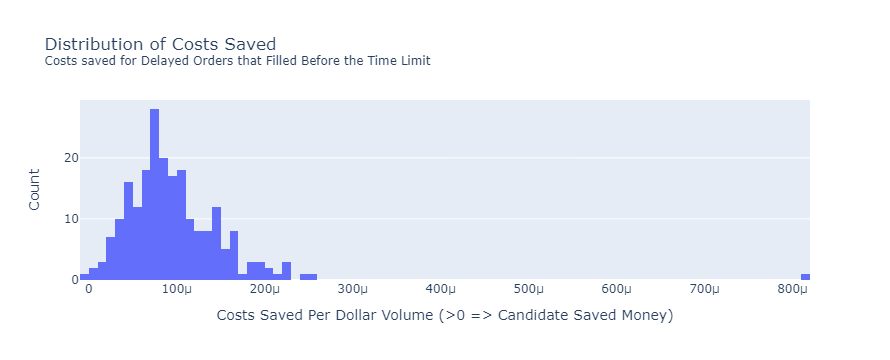

Number of orders: 219
Number of orders that lowered costs: 218 (59.56% of all orders)
Number of orders that didn't change costs: 0 (0.0% of all orders)
Number of orders that raised costs: 1 (0.27% of all orders)
Total costs saved: $6884.4


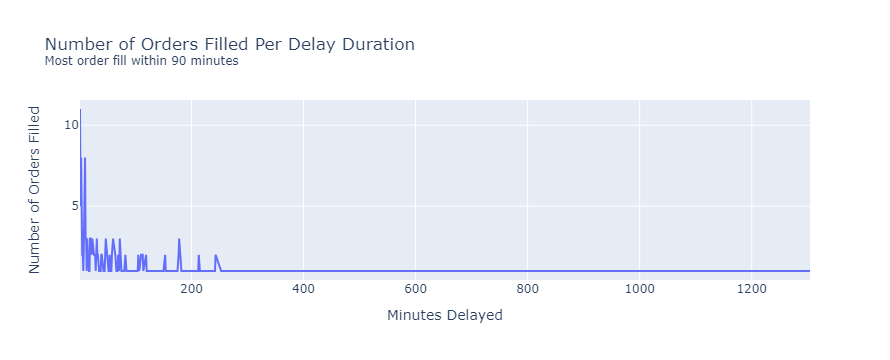

In [3]:
from collections import Counter
import plotly.graph_objects as go

# Calculate number of orders that the algorithm delayed (and didn't hit 
# the time limit).
index_numbers_of_time_limited_orders = []
index_numbers_of_delayed_orders = []
for i in range(len(benchmark_orders.index)):
    # Skip orders that filled at the same time.
    if benchmark_orders.index[i] == candidate_orders.index[i]:
        continue
    # Skip orders that hit the time limit.
    if "Hit time limit" in candidate_orders.iloc[i]['tag']:
        index_numbers_of_time_limited_orders.append(i)
        continue
    index_numbers_of_delayed_orders.append(i)

def display_order_results(title, index_numbers):
    cost_deltas = (
        benchmark_orders.iloc[index_numbers]['cost'].values 
        - candidate_orders.iloc[index_numbers]['cost'].values
    )
    candidate_dollar_volume = (
        abs(candidate_orders.iloc[index_numbers]['quantity']) 
        * candidate_orders.iloc[index_numbers]['fill_price']
    ).values
    cost_deltas_per_dollar_volume = cost_deltas / candidate_dollar_volume

    fig = go.Figure(data=[go.Histogram(x=cost_deltas_per_dollar_volume, nbinsx=100)])
    fig.update_layout(
        title="Distribution of Costs Saved<br><sup>Costs saved for "
            + f"Delayed Orders that {title}</sup>",
        xaxis_title="Costs Saved Per Dollar Volume (>0 => Candidate Saved Money)",
        yaxis_title="Count"
    )
    fig.show()

    print("Number of orders:", len(index_numbers))
    pct_of_cheaper_orders = (
        len(cost_deltas[cost_deltas > 0]) 
        / len(candidate_orders) * 100
    )
    print(
        "Number of orders that lowered costs:", 
        len(cost_deltas[cost_deltas > 0]),
        f"({round(pct_of_cheaper_orders, 2)}% of all orders)"
    )
    pct_of_no_change = (
        len(cost_deltas[cost_deltas == 0]) 
        / len(candidate_orders) * 100
    )
    print(
        "Number of orders that didn't change costs:", 
        len(cost_deltas[cost_deltas == 0]),
        f"({round(pct_of_no_change, 2)}% of all orders)"
    )
    pct_of_raised_orders = (
        len(cost_deltas[cost_deltas < 0]) 
        / len(candidate_orders) * 100
    )
    print(
        "Number of orders that raised costs:",
        len(cost_deltas[cost_deltas < 0]),
        f"({round(pct_of_raised_orders, 2)}% of all orders)"
    )
    print(f"Total costs saved: ${round(sum(cost_deltas), 2)}")

display_order_results(
    "Filled Before the Time Limit", index_numbers_of_delayed_orders
)

minutes_delayed = (
    candidate_orders.iloc[index_numbers_of_delayed_orders].index
    - benchmark_orders.iloc[index_numbers_of_delayed_orders].index
)
num_orders_by_delay_duration = pd.Series(
    Counter([x.total_seconds() / 60 for x in minutes_delayed])
).sort_index()

fig = go.Figure(
    go.Scatter(
        x=num_orders_by_delay_duration.index, 
        y=num_orders_by_delay_duration.values, mode='lines'
    )
)
fig.update_layout(
    title="Number of Orders Filled Per Delay Duration<br><sup>Most order fill "
        + "within 90 minutes</sup>",
    xaxis_title="Minutes Delayed",
    yaxis_title="Number of Orders Filled"
)
fig.show()

### Analysis of Delayed Orders That Hit the Time Limit

Now let's take a look at just the exit orders that hit the time limit and how their costs compare to the costs of the benchmark orders.

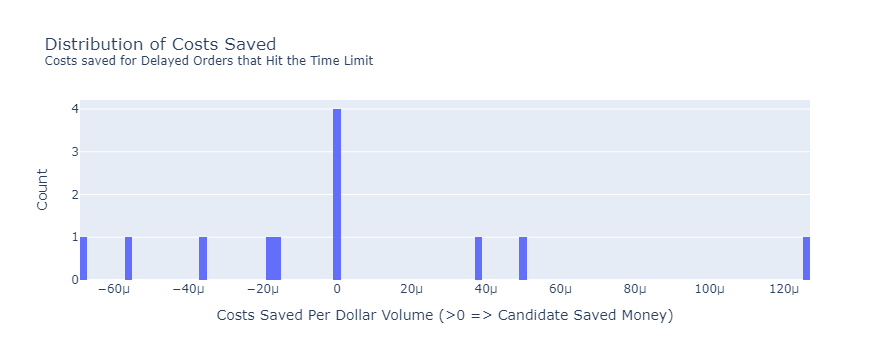

Number of orders: 12
Number of orders that lowered costs: 3 (0.82% of all orders)
Number of orders that didn't change costs: 4 (1.09% of all orders)
Number of orders that raised costs: 5 (1.37% of all orders)
Total costs saved: $4.1


In [4]:
display_order_results(
    "Hit the Time Limit", index_numbers_of_time_limited_orders
)